# 3. MPilotNet

## 3.1 data_gen

In [9]:
import csv
import numpy as np
from math import ceil, floor

from sklearn.model_selection import train_test_split


def read_data(csv_path, length, dim=2, target_height=None, target_width=None):
    """ Reading ultrasonic data from csv file
    Args: 
     - csv_path: the path of the csv file
     - length: the length of time-ordered sequence data to be read for each sample

    Return: 
     - train_X, train_Y, valid_X, valid_Y
    """
    
    height = length
    width = 16
    
    if dim == 3:
        # for a tensor representation 
        length=3*length

    X = []
    Y = []
    with open(csv_path, 'r') as f:
        f_reader = csv.reader(f)
        for line in f_reader:
            distance = [float(line[j+i*18]) for i in range(length) for j in range(16)]
            # use the last angular value in sequence data as label
            angle  = float(line[17+(length-1)*18])
            #[float(line[17+i*18]) for i in range(length)]
            X.append(distance)
            Y.append(angle)
    
    print("{} samples with length {} have been read from {}.".format(len(X), 
                                                                     length,
                                                                     csv_path))
    n_samples = len(X)
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)


    ## Date representation
    if target_height == None: target_height = height
    if target_width  == None: target_width  = width 
        
    h_repeats = int(ceil(target_height/float(height)))
    w_repeats = int(ceil(target_width/float(width)))
    
    h_delta = h_repeats*height-target_height
    w_delta = w_repeats*width-target_width
    
    h_start = int(floor(h_delta/2.0))
    h_end = h_repeats*height-(h_delta-h_start)
    
    w_start = int(floor(w_delta/2.0))
    w_end = w_repeats*width-(w_delta-w_start)
    
    if dim == 1:
        # shape (n, 16xlength)
        pass
      
    elif dim == 2:
        # reshape
        X = X.reshape(n_samples, 1, height, width)
        
        X = X.repeat(h_repeats, axis=2)
        X = X.repeat(w_repeats, axis=3)
        
        X = X[:,:,h_start:h_end, w_start:w_end]
                
    elif dim == 3:
        # 之前是直接把二维图片重复3次，形成第三维
        # dist = dist.repeat(dim, axis=0)
        X = X.reshape(n_samples, 3, height, width)
        
        X = X.repeat(h_repeats, axis=2)
        X = X.repeat(w_repeats, axis=3)
        
        X = X[:,:,h_start:h_end, w_start:w_end]
                
    else:
        raise IOError("Unidentified dim value: use 1, 2 or 3")

    print("X shape: {}, Y shape: {}".format(X.shape, Y.shape))
    
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y,
                                                          test_size=0.2,
                                                          random_state=10,
                                                          shuffle = False)

    return X_train, Y_train, X_valid, Y_valid 

## 3.2 model

In [20]:
from keras.models import Model
from keras.layers import Input, Lambda, Conv2D, Flatten, Dense, Dropout

from keras import backend as K
# set channels_first for all models
K.set_image_data_format("channels_first")



def mpilotnet(channels, height, width):
    """
    baseline 建立思路：
    1. 五层卷积不动，根据卷积确定合适的输入尺寸
    2. 前期实验表明(确定最佳时序时)，多个全连接层效果并不如单层的好，因此我们仅保留一层，并添加dropout
    3. 隐藏层大小根据最佳时序对应的确定？
    
    后期提升思路：
    1. 修改合适的卷积核大小
    2. 最后再加个隐藏层？
    
    """
    # (66,200,3)

    # Input
    inputs = Input(shape=(channels, height, width))
    
    # Normalize to [-0.5, 0.5]
    inputs_norm = Lambda(lambda x: (x-2.5)/5.0)(inputs)
    
    conv1 = Conv2D(24, kernel_size=(5,5), strides=(2,2), padding='valid', 
                   activation='relu')(inputs_norm)

    conv2 = Conv2D(36, kernel_size=(5,5), strides=(2,2), padding='valid', 
                   activation='relu')(conv1)

    conv3 = Conv2D(48, kernel_size=(5,5), strides=(2,2), padding='valid',
                   activation='relu')(conv2)

    conv4 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid',
                   activation='relu')(conv3)

    conv5 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid',
                   activation='relu')(conv4)

    flatten = Flatten()(conv5)
    
    x = Dropout(0.5)(flatten)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    steer = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=steer)

    return model


In [11]:

from keras import backend as K

def rmse(y_true, y_pred):
    """ Root Mean Squared Error 
    """
    return K.sqrt(K.mean(K.square(y_true-y_pred)))

def r_square(y_true, y_pred):
    """ R Square Score
    """
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    
    return 1 - SS_res/K.clip(SS_tot,K.epsilon(),None)

## 3.3 evaluation

In [12]:
import csv

from keras.optimizers import Adam
data_path='/media/ubuntu16/Documents/datasets/Sonar/SIM/Track-I-II/2019-07-03-48.csv'
length = 12
dim = 2
height = 66
width = 200
channels = 1

restore_weights_path='/home/ubuntu16/catkin_ws/src/sonar_navigation/output/V200/weights/1_weights_66_0.8542.h5'

X_train, Y_train, X_valid, Y_valid = read_data(csv_path=data_path, 
                                                   length=length, 
                                                   dim=dim, 
                                                   target_height=height,
                                                   target_width=width)


# model
model = mpilotnet(channels, height, width)
model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=[rmse, 'mae', r_square])
model.summary()

model.load_weights(restore_weights_path)

outputs = model.predict(X_valid,verbose=1)

with open('2.csv', 'w') as f:
    ff = csv.writer(f)
    
    ff.writerows(outputs)

45078 samples with length 12 have been read from /media/ubuntu16/Documents/datasets/Sonar/SIM/Track-I-II/2019-07-03-48.csv.
X shape: (45078, 1, 66, 200), Y shape: (45078,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 66, 200)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 66, 200)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 31, 98)        624       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 14, 47)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 5, 22)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 

In [23]:
# 其实就是原始数据文件中的第12列，36063-45078行
with open('2.csv', 'w') as f:
    ff = csv.writer(f)
    for value in Y_valid:
        ff.writerow([value])

In [ ]:
import csv

from keras.optimizers import Adam
data_path='/media/ubuntu16/Documents/datasets/Sonar/SIM/Track-I-II/2019-07-03-48.csv'
length = 12
dim = 3
height = 66
width = 200
channels = 3

restore_weights_path='/home/ubuntu16/catkin_ws/src/sonar_navigation/output/V201/weights/1_weights_86_0.8785.h5'

X_train, Y_train, X_valid, Y_valid = read_data(csv_path=data_path, 
                                                   length=length, 
                                                   dim=dim, 
                                                   target_height=height,
                                                   target_width=width)


# model
model = mpilotnet(channels, height, width)
model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=[rmse, 'mae', r_square])
model.summary()

model.load_weights(restore_weights_path)

outputs = model.predict(X_valid,verbose=1)

with open('3.csv', 'w') as f:
    ff = csv.writer(f)
    
    ff.writerows(outputs)

45078 samples with length 36 have been read from /media/ubuntu16/Documents/datasets/Sonar/SIM/Track-I-II/2019-07-03-48.csv.
X shape: (45078, 3, 66, 200), Y shape: (45078,)


### plot

In [1]:
import csv
with open('mpilotnet-2.csv', 'r') as f:
    reader = csv.reader(f)
    
    predicts2 = []
    truth2 = []
    for line in reader:
        predicts2.append(float(line[0]))
        truth2.append(float(line[1]))
        
with open('mpilotnet-3.csv', 'r') as f:
    reader = csv.reader(f)
    
    predicts3 = []
    truth3 = []
    for line in reader:
        predicts3.append(float(line[0]))
        truth3.append(float(line[1]))

In [2]:
print len(predicts2)
print len(truth3)

9016
9016


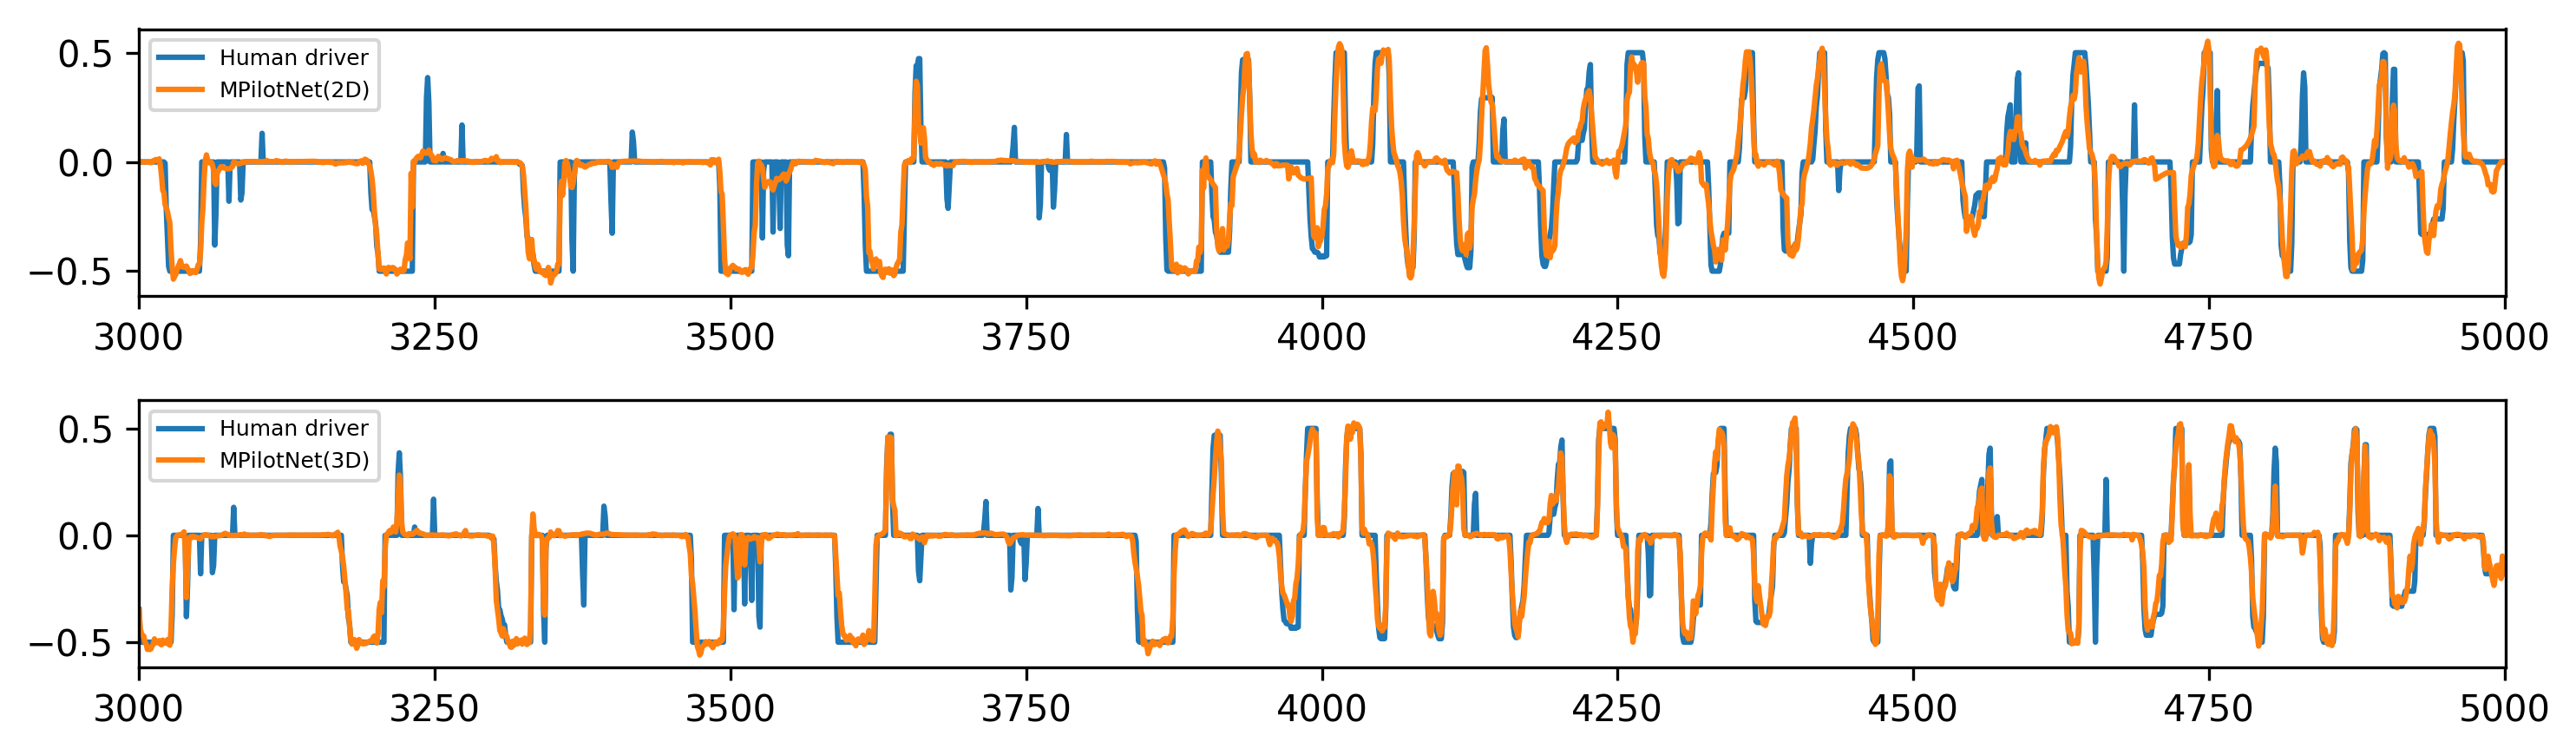

In [3]:
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,3), dpi=300)

x = np.arange(3000,5001,1)
ax1.plot(x, truth2[3000:5001], label="Human driver")
ax1.plot(x, predicts2[3000:5001], label="MPilotNet(2D)")
ax1.set_xlim(3000,5001)
#ax1.set_xticks(np.arange(0, 49, 6))
#ax1.set_xlabel("Validation Data")
#ax1.set_ylabel("Angular Velocity")
ax1.legend(prop={'size':6})

#ax12.plot(x, baseline_r_square)
ax2.plot(x, truth3[3000:5001], label="Human driver")
ax2.plot(x, predicts3[3000:5001], label="MPilotNet(3D)")
ax2.set_xlim(3000,5001)
#ax2.set_xticks(np.arange(0, 49, 6))
#ax2.set_xlabel("Sequence Length")
#ax2.set_ylabel("R2 & R2_adjust")
ax2.legend(prop={'size':6})


fig.tight_layout()
fig.savefig('prediction.png')

plt.show()